In [5]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.neuralnetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Paramaters

In [6]:
base_seed = 42
base_feature_size = 9
baseline_accuracy = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [7]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [8]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


c:\Users\Mihai\miniconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [9]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 32, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9584722222222222


### Assesing performance

In [10]:
nn_results = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9569444444444445
Run 2 / 10 started
Run finished with test accuracy: 0.9625
Run 3 / 10 started
Run finished with test accuracy: 0.9569444444444445
Run 4 / 10 started
Run finished with test accuracy: 0.9527777777777777
Run 5 / 10 started
Run finished with test accuracy: 0.9563888888888888
Run 6 / 10 started
Run finished with test accuracy: 0.9541666666666667
Run 7 / 10 started
Run finished with test accuracy: 0.9594444444444444
Run 8 / 10 started
Run finished with test accuracy: 0.9538888888888889
Run 9 / 10 started
Run finished with test accuracy: 0.9561111111111111
Run 10 / 10 started
Run finished with test accuracy: 0.9544444444444444


In [11]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.691470        0.529167       0.956944
1     0      1    0.655219        0.677222       0.956944
2     0      2    0.556533        0.765556       0.956944
3     0      3    0.407327        0.855903       0.956944
4     0      4    0.316696        0.893958       0.956944


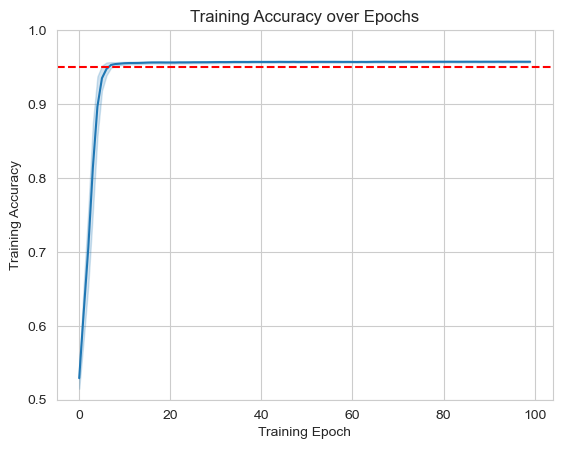

In [12]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

# Random Forrests

In [13]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [14]:
forrest_results = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9588888888888889
Run 2 / 10 started
Run finished with test accuracy: 0.9633333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9586111111111111
Run 4 / 10 started
Run finished with test accuracy: 0.9555555555555556
Run 5 / 10 started
Run finished with test accuracy: 0.9577777777777777
Run 6 / 10 started
Run finished with test accuracy: 0.9558333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9611111111111111
Run 8 / 10 started
Run finished with test accuracy: 0.9563888888888888
Run 9 / 10 started
Run finished with test accuracy: 0.9566666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.9558333333333333


In [15]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.958889
1    1       0.963333
2    2       0.958611
3    3       0.955556
4    4       0.957778
5    5       0.955833
6    6       0.961111
7    7       0.956389
8    8       0.956667
9    9       0.955833


In [16]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.958
Baseline to beat 0.95


# Logistic Regression

In [17]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [18]:
params = {
    'alpha': [0.1, 0.15, 0.2],
    'max_iter': [1500],
    'tol': [1e-3],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.001],
}

logreg = SGDClassifier(loss='log_loss', n_jobs=-1)

gs = GridSearchCV(logreg, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [19]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.9584722222222222


### Assessing Performance

In [20]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9588888888888889
Run 2 / 10 started
Run finished with test accuracy: 0.9633333333333334
Run 3 / 10 started
Run finished with test accuracy: 0.9586111111111111
Run 4 / 10 started
Run finished with test accuracy: 0.9555555555555556
Run 5 / 10 started
Run finished with test accuracy: 0.9577777777777777
Run 6 / 10 started
Run finished with test accuracy: 0.9558333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9611111111111111
Run 8 / 10 started
Run finished with test accuracy: 0.9563888888888888
Run 9 / 10 started
Run finished with test accuracy: 0.9566666666666667
Run 10 / 10 started
Run finished with test accuracy: 0.9558333333333333


In [21]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.958889
1    1       0.963333
2    2       0.958611
3    3       0.955556
4    4       0.957778
5    5       0.955833
6    6       0.961111
7    7       0.956389
8    8       0.956667
9    9       0.955833


In [22]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.958
Baseline to beat 0.95
